DataSet Link: 
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [17]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [18]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'cell_images/train'
valid_path = 'cell_images/test'

In [19]:
# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [20]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [22]:
# useful for getting number of output classes
folders = glob('cell_images/train/*')

In [23]:
folders

['cell_images/train/Parasitized', 'cell_images/train/Uninfected']

In [24]:
# our layers - you can add more if you want
x = Flatten()(vgg19.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [26]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [27]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [63]:
# Generate training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('cell_images/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 1026 images belonging to 2 classes.


In [64]:
# Generate test set (only rescale)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('cell_images/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 246 images belonging to 2 classes.


In [65]:
# fit the model and store the history

fit_hist = model.fit(
    training_set,
    validation_data = test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/10
65/65 [==============================] - 55s 852ms/step - loss: 0.2551 - accuracy: 0.8899 - val_loss: 1.5780 - val_accuracy: 0.5894
Epoch 2/10
65/65 [==============================] - 55s 851ms/step - loss: 0.2522 - accuracy: 0.8899 - val_loss: 1.1985 - val_accuracy: 0.6382
Epoch 3/10
65/65 [==============================] - 55s 842ms/step - loss: 0.3225 - accuracy: 0.8616 - val_loss: 0.6151 - val_accuracy: 0.7724
Epoch 4/10
65/65 [==============================] - 55s 847ms/step - loss: 0.2539 - accuracy: 0.8918 - val_loss: 1.1313 - val_accuracy: 0.6545
Epoch 5/10
65/65 [==============================] - 55s 850ms/step - loss: 0.2072 - accuracy: 0.9220 - val_loss: 0.5004 - val_accuracy: 0.8252
Epoch 6/10
65/65 [==============================] - 55s 849ms/step - loss: 0.2194 - accuracy: 0.9064 - val_loss: 0.7496 - val_accuracy: 0.7764
Epoch 7/10
65/65 [==============================] - 55s 850ms/step - loss: 0.2931 - accuracy: 0.8899 - val_loss: 1.3678 - val_accuracy: 0.6545

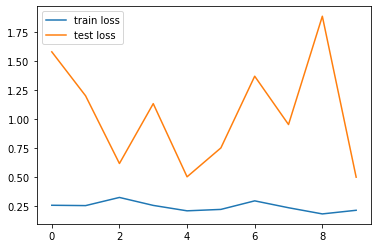

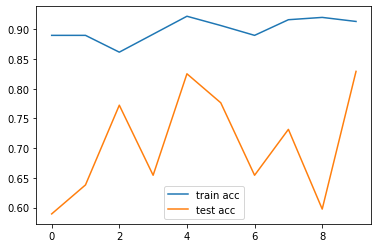

<Figure size 432x288 with 0 Axes>

In [66]:
# plot the loss
plt.plot(fit_hist.history['loss'], label='train loss')
plt.plot(fit_hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss')

# plot the accuracy
plt.plot(fit_hist.history['accuracy'], label='train acc')
plt.plot(fit_hist.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
plt.savefig('Acc')

In [184]:
# save model as a h5 file

from tensorflow.keras.models import load_model

model.save('model_vgg.h5')

vgg19.save('raw_vgg.h5')

# Prediction for test set

In [68]:
y_pred = model.predict(test_set)
y_pred

array([[9.41294253e-01, 5.87057918e-02],
       [4.16131765e-02, 9.58386779e-01],
       [9.96528566e-01, 3.47143854e-03],
       [2.58340361e-03, 9.97416615e-01],
       [9.86215174e-01, 1.37847988e-02],
       [3.30858588e-01, 6.69141471e-01],
       [2.12039594e-02, 9.78796065e-01],
       [9.04612780e-01, 9.53872502e-02],
       [8.55974376e-01, 1.44025594e-01],
       [2.48754222e-04, 9.99751270e-01],
       [2.17131078e-02, 9.78286922e-01],
       [4.62399200e-02, 9.53760087e-01],
       [8.74296367e-01, 1.25703618e-01],
       [6.84375286e-01, 3.15624774e-01],
       [1.17550259e-02, 9.88245010e-01],
       [6.14431640e-03, 9.93855655e-01],
       [3.21208686e-03, 9.96787906e-01],
       [9.99521971e-01, 4.78011585e-04],
       [3.51837695e-01, 6.48162365e-01],
       [6.32993281e-01, 3.67006689e-01],
       [4.24153125e-03, 9.95758474e-01],
       [9.86132622e-01, 1.38674546e-02],
       [1.30289630e-03, 9.98697102e-01],
       [8.59695911e-01, 1.40304089e-01],
       [9.818851

In [69]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1])

# Predict the class of a single image

In [162]:
img=image.load_img('cell_images/test/Uninfected/C75P36_ThinF_IMG_20150815_163707_cell_33.png',target_size=(224,224))

In [163]:
x=image.img_to_array(img)

In [164]:
x.shape

(224, 224, 3)

In [165]:
x=x/255

In [166]:
x=np.expand_dims(x,axis=0)

In [179]:
N = model.predict(x)[0]
N.shape

(2,)

In [168]:
a=np.argmax(model.predict(x), axis=1)
a

In [170]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
